## Task 2.6 - Building model with Deep Learning
Check GPU

In [45]:

#!nvidia-smi -L

# Importing Libraries

In [2]:

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:

train = pd.read_csv("/content/drive/MyDrive/Deep learning/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Deep learning/test.csv")

In [5]:

train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [6]:


train.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


In [7]:

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB



1. Isolate the Rossmann Store Sales dataset into time series data



In [8]:

class MissingFinder:
  def percent_missing(self, df: pd.DataFrame) ->float:
    totalCells = np.product(df.shape)
    missingCount = df.isnull().sum()
    totalMissing = missingCount.sum()
    return round((totalMissing / totalCells) * 100, 2)

missing_finder = MissingFinder()

missing_percentage = missing_finder.percent_missing(train)
missing_percentage

0.0

In [9]:
# Extracting the "Date" and "Sales" columns
def get_feature(df):
    return df[["Date", "Sales"]]

In [10]:
# Drop the column closed
def drop_closed(df):
    df = df[df['Open'] == 1]
    return df

In [11]:
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler

In [12]:

def scaler(df, columns, mode="minmax"):
    scaler_dict = {
        "minmax": MinMaxScaler(),
        "standard": StandardScaler(),
        "robust": RobustScaler()
    }

    selected_scaler = scaler_dict.get(mode)
    if selected_scaler:
        scaled_data = selected_scaler.fit_transform(df)
        return pd.DataFrame(scaled_data, columns=columns), selected_scaler
    else:
        raise ValueError("Invalid mode. Supported modes: minmax, standard, robust")


In [13]:

def add_scaled_sales(df):
    scaled_sales, scaler_obj = scaler(df[["Sales"]], mode="minmax", columns=["scaled_sales"])
    df["scaled_sales"] = scaled_sales["scaled_sales"].tolist()
    return df, scaler_obj


In [14]:

# Handle the outliers

def handle_outliers(df, col, method="lower_upper"):
   df = df.copy()
   q1 = df[col].quantile(0.25)
   q3 = df[col].quantile(0.75)

   lower_bound = q1 - ((1.5) * (q3 - q1))
   upper_bound = q3 + ((1.5) * (q3 - q1))

   if method == "mean":
    df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
    df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

   elif  method == "mode":
    df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
    df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
   else:
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

   return df

In [15]:
train["Sales"] = train["Sales"].astype("float")

In [16]:

data = drop_closed(train)
data = get_feature(data)
data = handle_outliers(data, "Sales")

In [17]:

data_agg = data.groupby("Date").agg({"Sales": "mean"})
missing_percentage = missing_finder.percent_missing(data_agg)

In [18]:

data_agg.head()

,Sales
Date,
2013-01-01,5504.676471
2013-01-02,6193.011701
2013-01-03,5686.321912
2013-01-04,5955.507671
2013-01-05,5330.833333


In [19]:

data_agg.describe()

,Sales
count,942.000000
mean,6988.142162
std,1475.510458
min,4057.782960
25%,5725.756766
50%,6822.535825
75%,7778.867102
max,11908.661883


In [20]:

from matplotlib.gridspec import GridSpec
from matplotlib import ticker


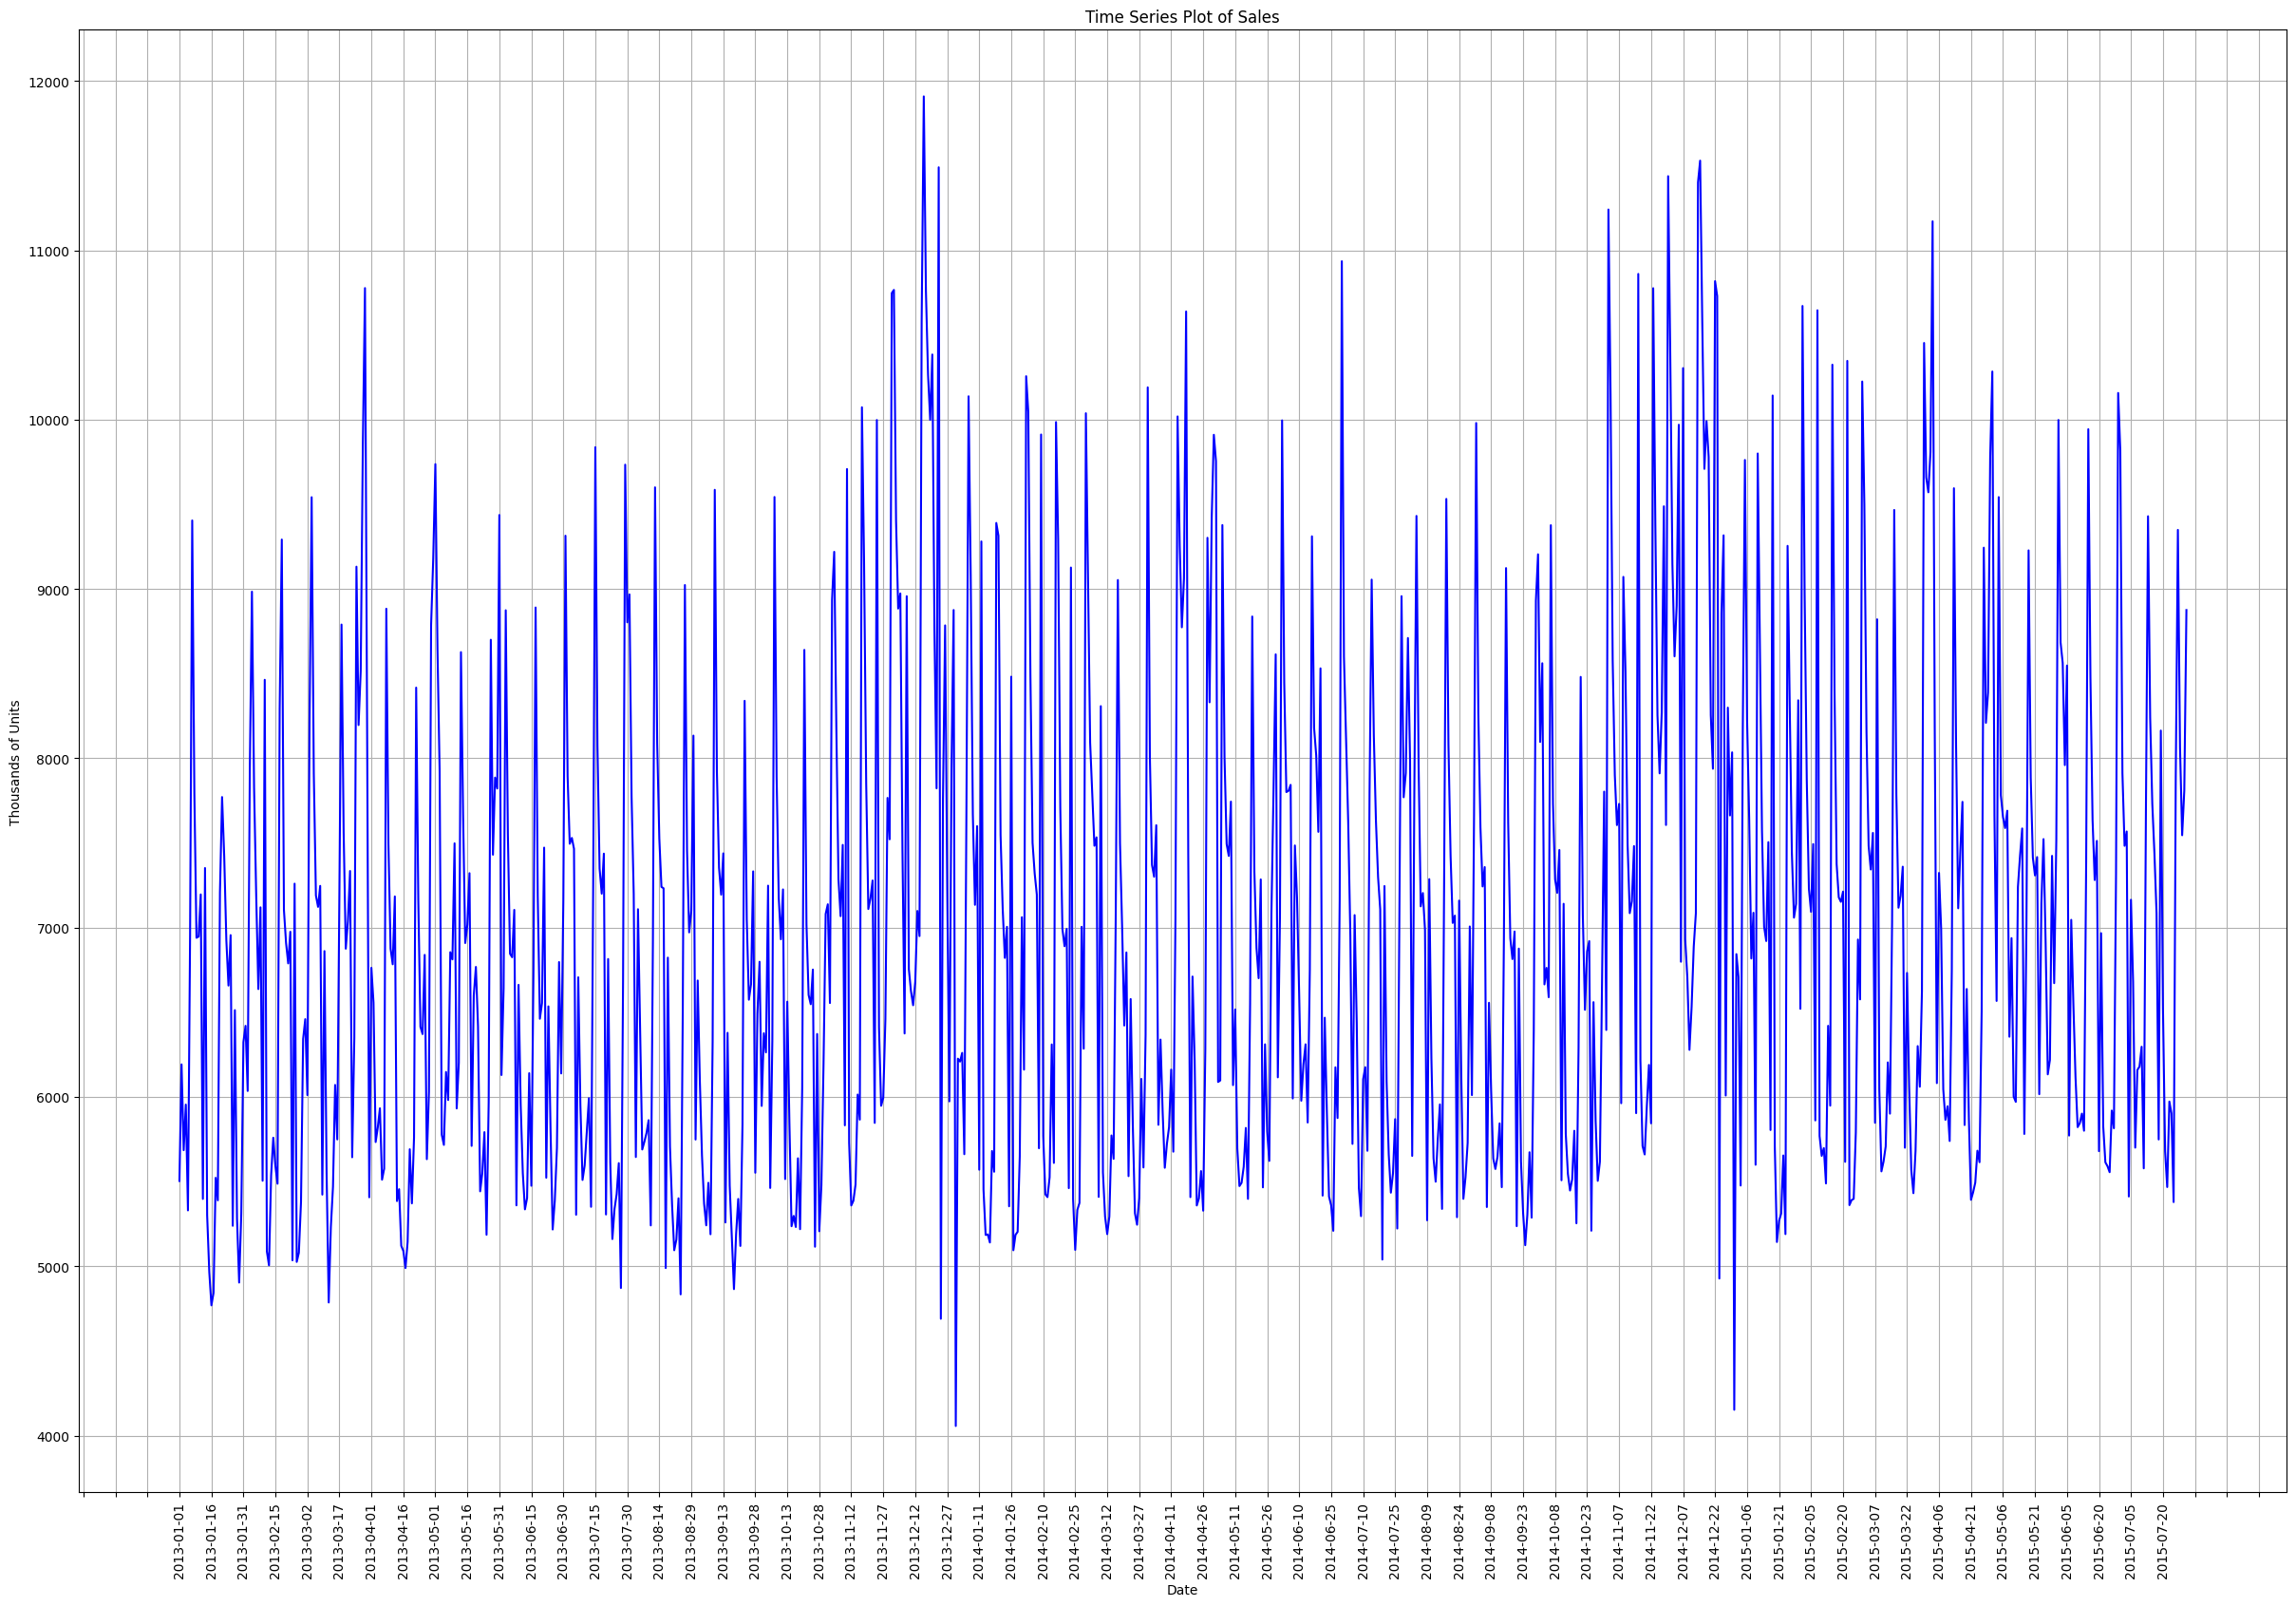

In [21]:

# Create a figure with the specified dimensions and layout
fig = plt.figure()
gs = GridSpec(2, 1, figure = fig)
fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

# Create a MaxNLocator for x-axis ticks
M = 100
xticks = ticker.MaxNLocator(M)

# Plot the time series data_agg
plt.plot(data_agg.index, data_agg.Sales, 'b-')

# Set the major locator for x-axis ticks
plt.gca().xaxis.set_major_locator(xticks)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set x and y-axis labels
plt.xlabel('Date')
plt.ylabel('Thousands of Units')

# Set the title of the plot
plt.title('Time Series Plot of Sales')

# Display grid lines
plt.grid(True)

# Show the plot
plt.show()

2. Check whether the Data is Stationary

In [22]:

from statsmodels.tsa.stattools import adfuller, acf, pacf

def check_stationarity(data, column):
  adfResult = adfuller(data[column].values, autolag='AIC')
  print(f'ADF Statistic: {adfResult[0]}')
  print(f'p-value: {adfResult[1]}')
  return adfResult[1] >= 0.05


# Assuming you have a DataFrame 'data' with a column "Sales"
check_stationarity(data_agg, "Sales")

ADF Statistic: -4.719271399336019
p-value: 7.741088433521471e-05


False

ADF Statistic; The ADF statistic is -4.719271399336019 which represents the measure of differencing required for the data to become stationary. In this case the ADF statistic is considerably more negative, than the values suggesting that the data series is likely to be stationary than non stationary.

p value; The p value associated with the ADF statistic is 7.741088433521471e-05 (a very small value close to 0). The p value helps determine the significance of the ADF statistic. When p value is less than 0.05. it indicates that we can reject the null hypothesis and conclude that the data is non stationary. However in this case a small p value suggests that we can reject the hypothesis and infer that the data is indeed stationary.

Boolean Result; The boolean result is False because the p value (7.741088433521471e-05) is less than 0.05. This implies that our data can be considered stationary.

Conclusion; Based on our analysis of ADF statistic p value and boolean result there exists evidence to support concluding that our "Sales" data series demonstrates characteristics of stationarity.

The p value being low implies that the data is highly likely to be stationary. This assertion is further supported by the negative value of the ADF statistic.

## 3. Depending on our conclusion from above lets difference our time series data

In [23]:

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [24]:
differenced_sales = difference(data_agg['Sales'], interval=1)

In [25]:
differenced_sales

0       688.335231
1      -506.689790
2       269.185760
3      -624.674338
4      1627.535088
          ...     
936    1457.478240
937   -1285.448787
938    -517.565139
939     263.162624
940    1066.487871
Length: 941, dtype: float64

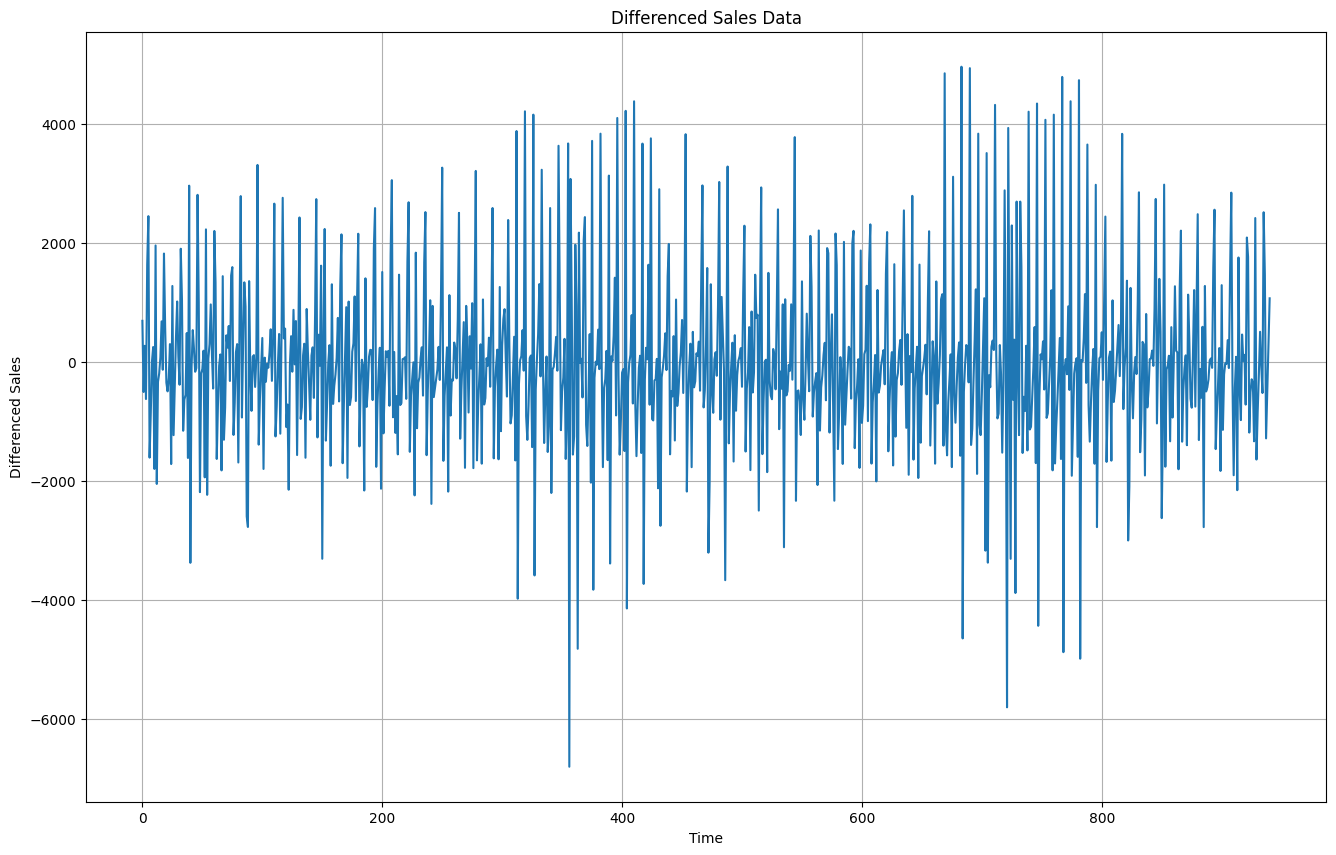

In [26]:

plt.figure(figsize=(16, 10))
plt.plot(differenced_sales)
plt.title('Differenced Sales Data')
plt.xlabel('Time')
plt.ylabel('Differenced Sales')
plt.grid(True)
plt.show()

## 4. Check for autocorrelation and partial autocorrelation of our data

<Figure size 3000x500 with 0 Axes>

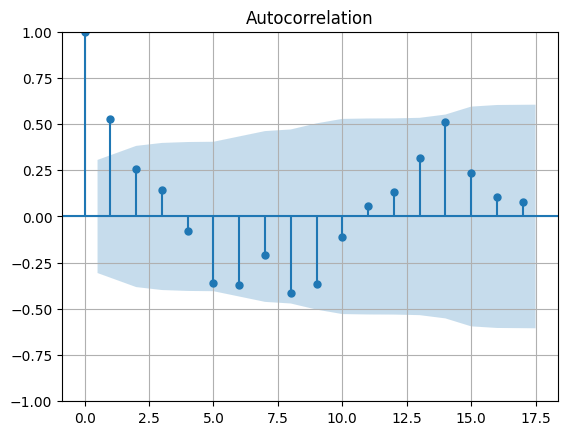

In [27]:

# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

plt.figure(figsize=(30, 5))
acfSalesScaled = acf(data_agg["Sales"].values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)
plot_acf(acfSalesScaledNp)
plt.grid(True)
plt.show()

ACF measures the correlation between a time series and its own lagged values at different time lags. Peaks or significant values in the ACF plot at specific lags indicate the presence of a seasonal or periodic pattern in the data.

ACF: Look for significant peaks in the ACF plot to identify potential seasonal or periodic patterns in the data. A gradual decay in ACF values as lags increase is a sign of stationarity.



We can see that there is positive lag at points 0,1,2,3,11,12,13,14,15,16,17 and negative lag at points 4,5,6,7,8,9,10. so the lags indicates the presence of seasonal and periodic pattern in tne data

<Figure size 3000x500 with 0 Axes>

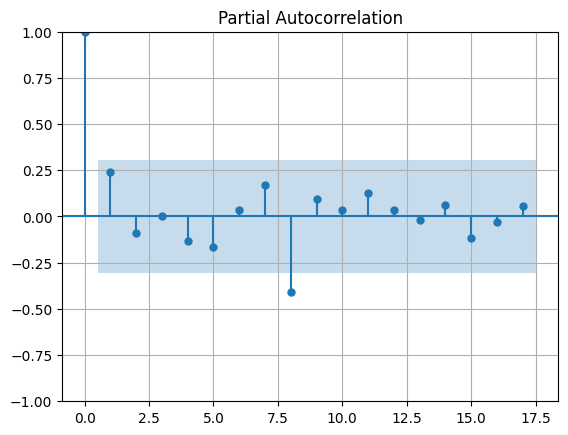

In [28]:

# Partial Autocorrelation
pacfSalesScaled = pacf(data_agg["Sales"].values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

plt.figure(figsize=(30, 5))
plot_pacf(pacfSalesScaledNp)
plt.grid(True)
plt.show()

PACF: Examine the PACF plot to identify the order of the autoregressive (AR) component in the data. Significant peaks in the PACF plot suggest the presence of AR terms in the model.

We can see there are significant positive and neagtive lags on the graph, It indicates that there is presence of an autoregressive (AR) component in the data.

Indicating the presence of an autoregressive (AR) component in time series data means that we have observed significant partial autocorrelation (PACF) values at specific lags in the PACF plot. PACF values that are significantly different from zero at certain lags suggest that there might be a dependency on past observations in the time series.

## 5. Transform the time series data into supervised learning data by creating a new y(target) column.

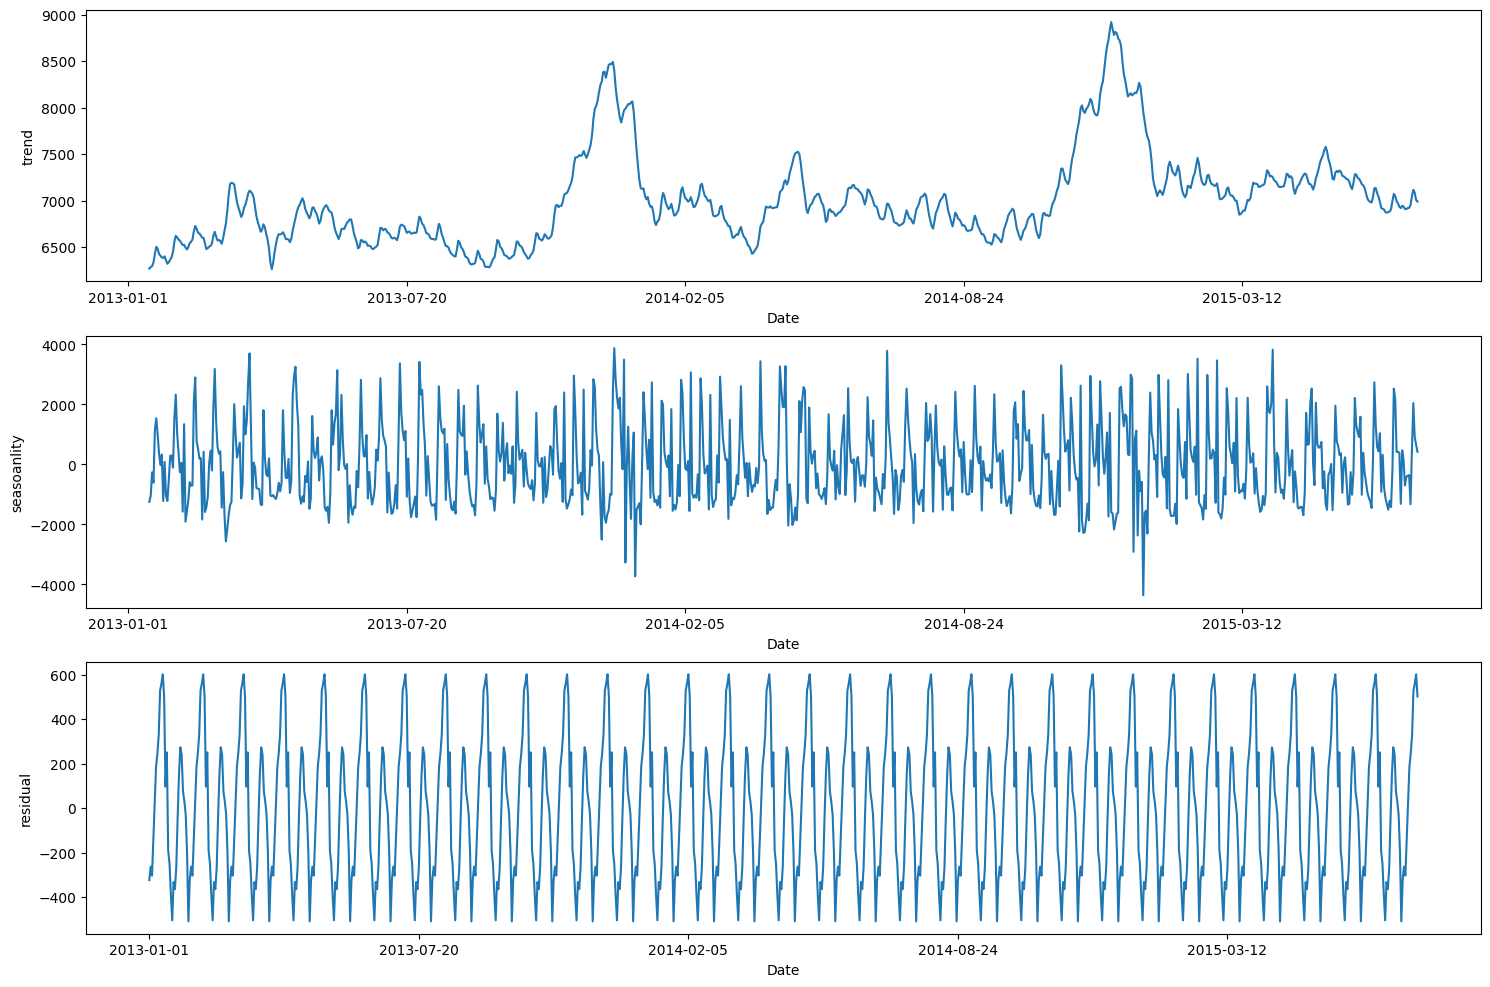

In [29]:

# Lets check the seasonal decomposition of the sales data
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data_agg, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(18,12))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

In [30]:
seasonal_component = res.seasonal
seasonal_component


Date
2013-01-01   -323.982078
2013-01-02   -263.075318
2013-01-03   -303.415139
2013-01-04   -136.788531
2013-01-05     37.737971
                 ...    
2015-07-27    329.692670
2015-07-28    528.467426
2015-07-29    560.663492
2015-07-30    601.808225
2015-07-31    501.902746
Name: seasonal, Length: 942, dtype: float64

In [31]:
data_agg.index = pd.to_datetime(data_agg.index)


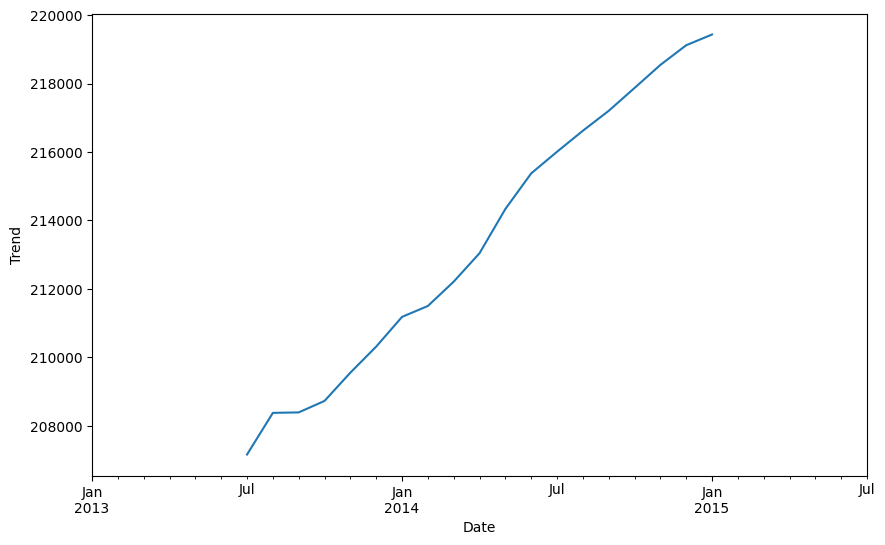

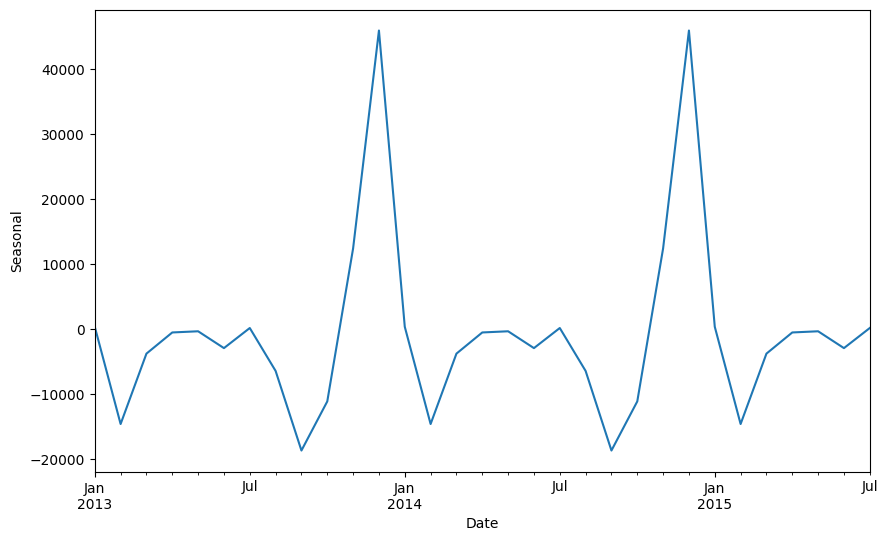

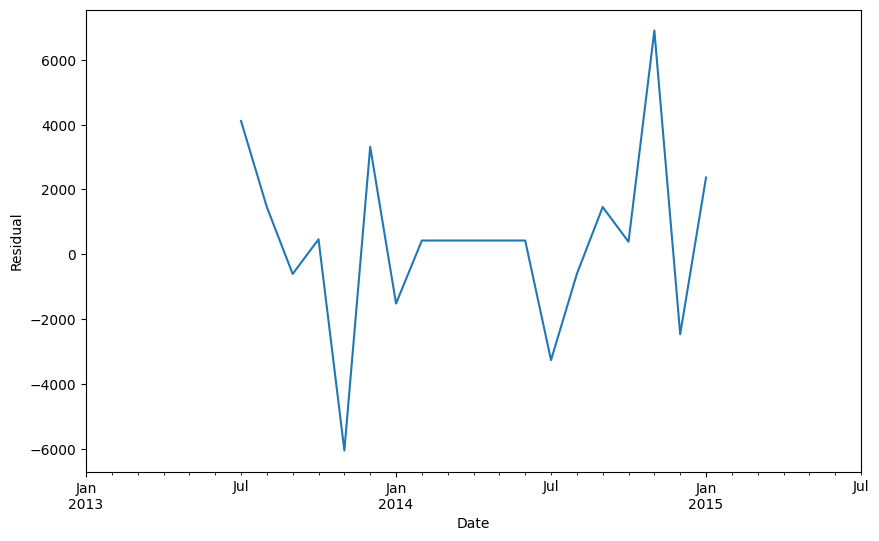

In [32]:

# Resample the data to monthly frequency
data_monthly = data_agg['Sales'].resample('M').sum()

# Perform seasonal decomposition (assuming additive model)
decomposition = seasonal_decompose(data_monthly, model='additive')

# Create a figure with custom size
plt.figure(figsize=(10, 6))

# Plot the decomposition components (trend, seasonal, residual)
decomposition.trend.plot()
plt.ylabel('Trend')
plt.xlabel('Date')


# Create a new figure for the seasonal component
plt.figure(figsize=(10, 6))
decomposition.seasonal.plot()
plt.ylabel('Seasonal')
plt.xlabel('Date')


# Create a new figure for the residual component
plt.figure(figsize=(10, 6))
decomposition.resid.plot()
plt.ylabel('Residual')
plt.xlabel('Date')
plt.show()

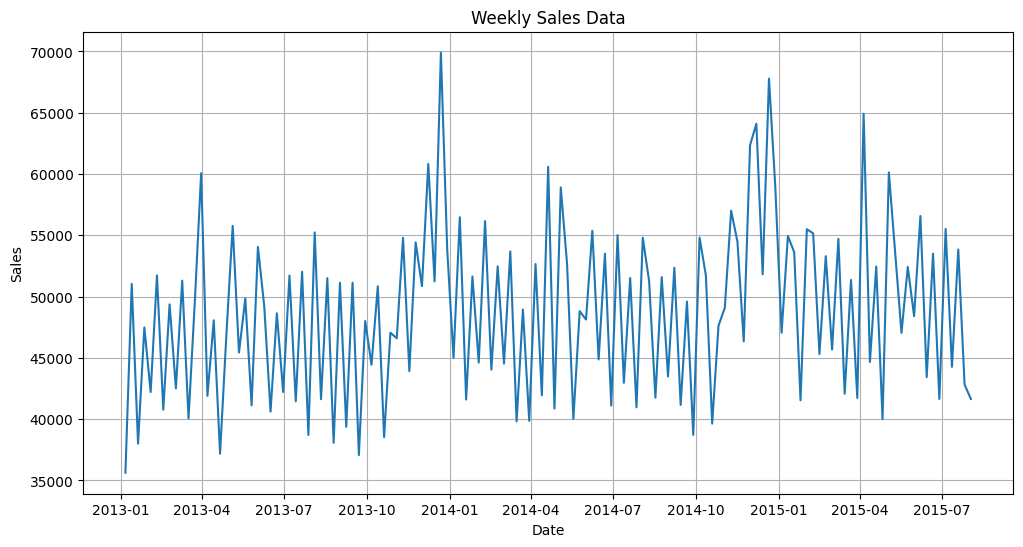

In [33]:

# Resample the data to weekly frequency
data_weekly = data_agg['Sales'].resample('W').sum()

# Plot the weekly sales data
plt.figure(figsize=(12, 6))
plt.plot(data_weekly)
plt.title('Weekly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

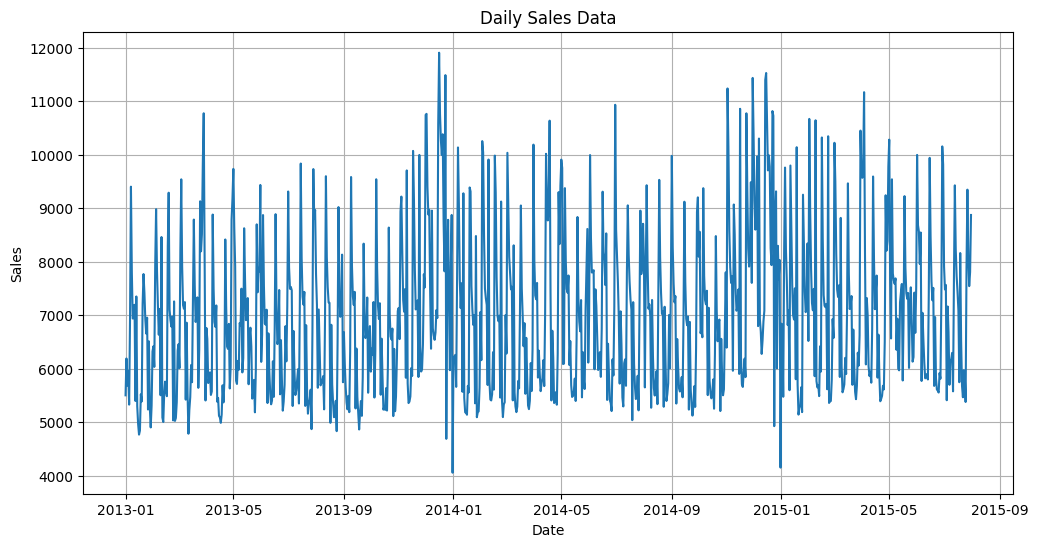

In [34]:

# Resample the data to daily frequency
data_daily = data_agg['Sales'].resample('D').sum()

# Plot the daily sales data
plt.figure(figsize=(12, 6))
plt.plot(data_daily)
plt.title('Daily Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [35]:

# Perform data scaling and check for missing values in a time series dataset
scaled_df, scaler_obj = add_scaled_sales(data_agg)
data_agg["Sales"].isna().any().sum()

0

## 6. Build a LSTM Regression model to predict the next sale

In [36]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import datetime
sns.set()

In [37]:

class TimeSeriesSalsesPred:

    def __init__(self, WINDOW_SIZE, BATCH_SIZE, sales_data):
        self.WINDOW_SIZE = WINDOW_SIZE
        self.BATCH_SIZE = BATCH_SIZE

        data_agg = sales_data.groupby("Date").agg({"Sales": "mean"})
        self.SIZE = len(data_agg["Sales"])

        self.scaled_df, self.scaler_obj = add_scaled_sales(data_agg)

        self.DateTrain = np.reshape(self.scaled_df.index.values[0:BATCH_SIZE], (-1, 1))
        self.DateValid = np.reshape(self.scaled_df.index.values[BATCH_SIZE:], (-1, 1))

        self.train_sales, self.valid_sales, self.TrainDataset, self.ValidDataset = self.prepare_data(WINDOW_SIZE,
                                                                                                     BATCH_SIZE,
                                                                                                     self.scaled_df)

    def prepare_data(self, WINDOW_SIZE, BATCH_SIZE, scaled_df):
        train_sales = scaled_df["scaled_sales"].values[0:BATCH_SIZE].astype('float32')
        valid_sales = scaled_df["scaled_sales"].values[BATCH_SIZE:].astype('float32')
        TrainDataset = self.windowed_dataset(train_sales, WINDOW_SIZE, BATCH_SIZE)
        ValidDataset = self.windowed_dataset(valid_sales, WINDOW_SIZE, BATCH_SIZE)

        return train_sales, valid_sales, TrainDataset, ValidDataset

    def train(self, EPOCHS, verbose=1, ):
      model = Sequential()
      model.add(LSTM(20, input_shape=[None, 1], return_sequences=True))
      model.add(LSTM(10, input_shape=[None, 1]))
      model.add(Dense(1))
      model.compile(loss="huber_loss", optimizer='adam')
      model.summary()

      history = model.fit(self.TrainDataset, epochs=EPOCHS, validation_data=self.ValidDataset, verbose=verbose)
      self.plot_history(history)

      return model, history

    def plot_history(self, history):
        fig = plt.figure(figsize=(12, 9))
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="val_loss")
        plt.legend()
        plt.show()

        return fig

    # LSTM model Forcast compared to Validtion Data
    def model_forecast_test(self, model):

        series = self.scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(self.WINDOW_SIZE, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(self.WINDOW_SIZE))
        ds = ds.batch(self.SIZE).prefetch(1)
        forecast = model.predict(ds)

        Results = forecast[self.BATCH_SIZE-self.WINDOW_SIZE:-1]
        Results1 = self.scaler_obj.inverse_transform(Results.reshape(-1,1))
        XValid1 = self.scaler_obj.inverse_transform(self.valid_sales.reshape(-1,1))

        fig, MAE, RMSE = self.plot_forcast(Results, Results1, XValid1, self.DateValid, self.WINDOW_SIZE)


        return forecast, fig, MAE, RMSE

    def plot_forcast(self, Results, Results1, XValid1, DateValid,  WINDOW_SIZE):
        fig = plt.figure(figsize=(30, 8))
        plt.title("LSTM Model Forecast Compared to Validation Data")

        plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
        plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')

        plt.xlabel('Date')
        plt.ylabel('Thousands of Units')
        plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90)
        plt.legend(loc="upper right")

        MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
        RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

        textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

        # place a text box in upper left in axes coords
        plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
        plt.grid(True)

        plt.show()

        return fig, MAE, RMSE





    def windowed_dataset(self, series, window_size, batch_size):
        series = tf.expand_dims(series, axis=-1)
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset


In [38]:

SIZE = len(data_agg["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

t = TimeSeriesSalsesPred(WINDOW_SIZE, BATCH_SIZE, data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.0833 - val_loss: 0.0772
Epoch 2/200
1/1 [==============================] - 0s 326ms/step - loss: 0.0779 - val_loss: 0.0727
Epoch 3/200
1/1 [==============================] - 0s 337ms/step - loss: 0.0734 - val_loss: 0.0680
Epoch 4/200
1/1 [=======

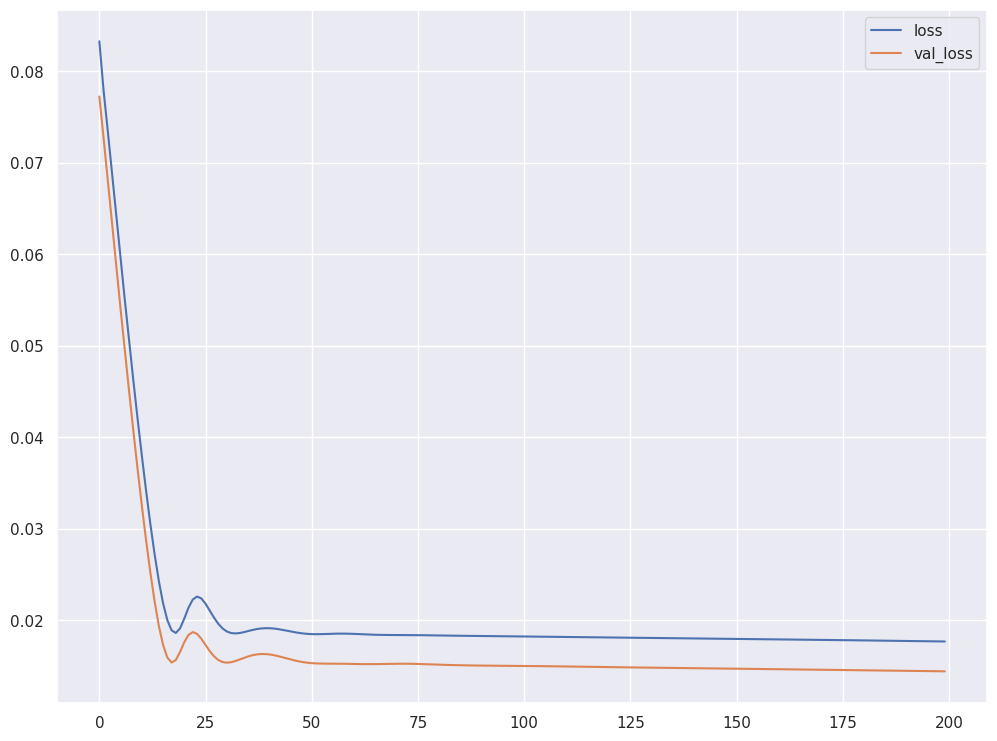

In [39]:

model1, his = t.train(EPOCHS)


1/1 [==============================] - 3s 3s/step


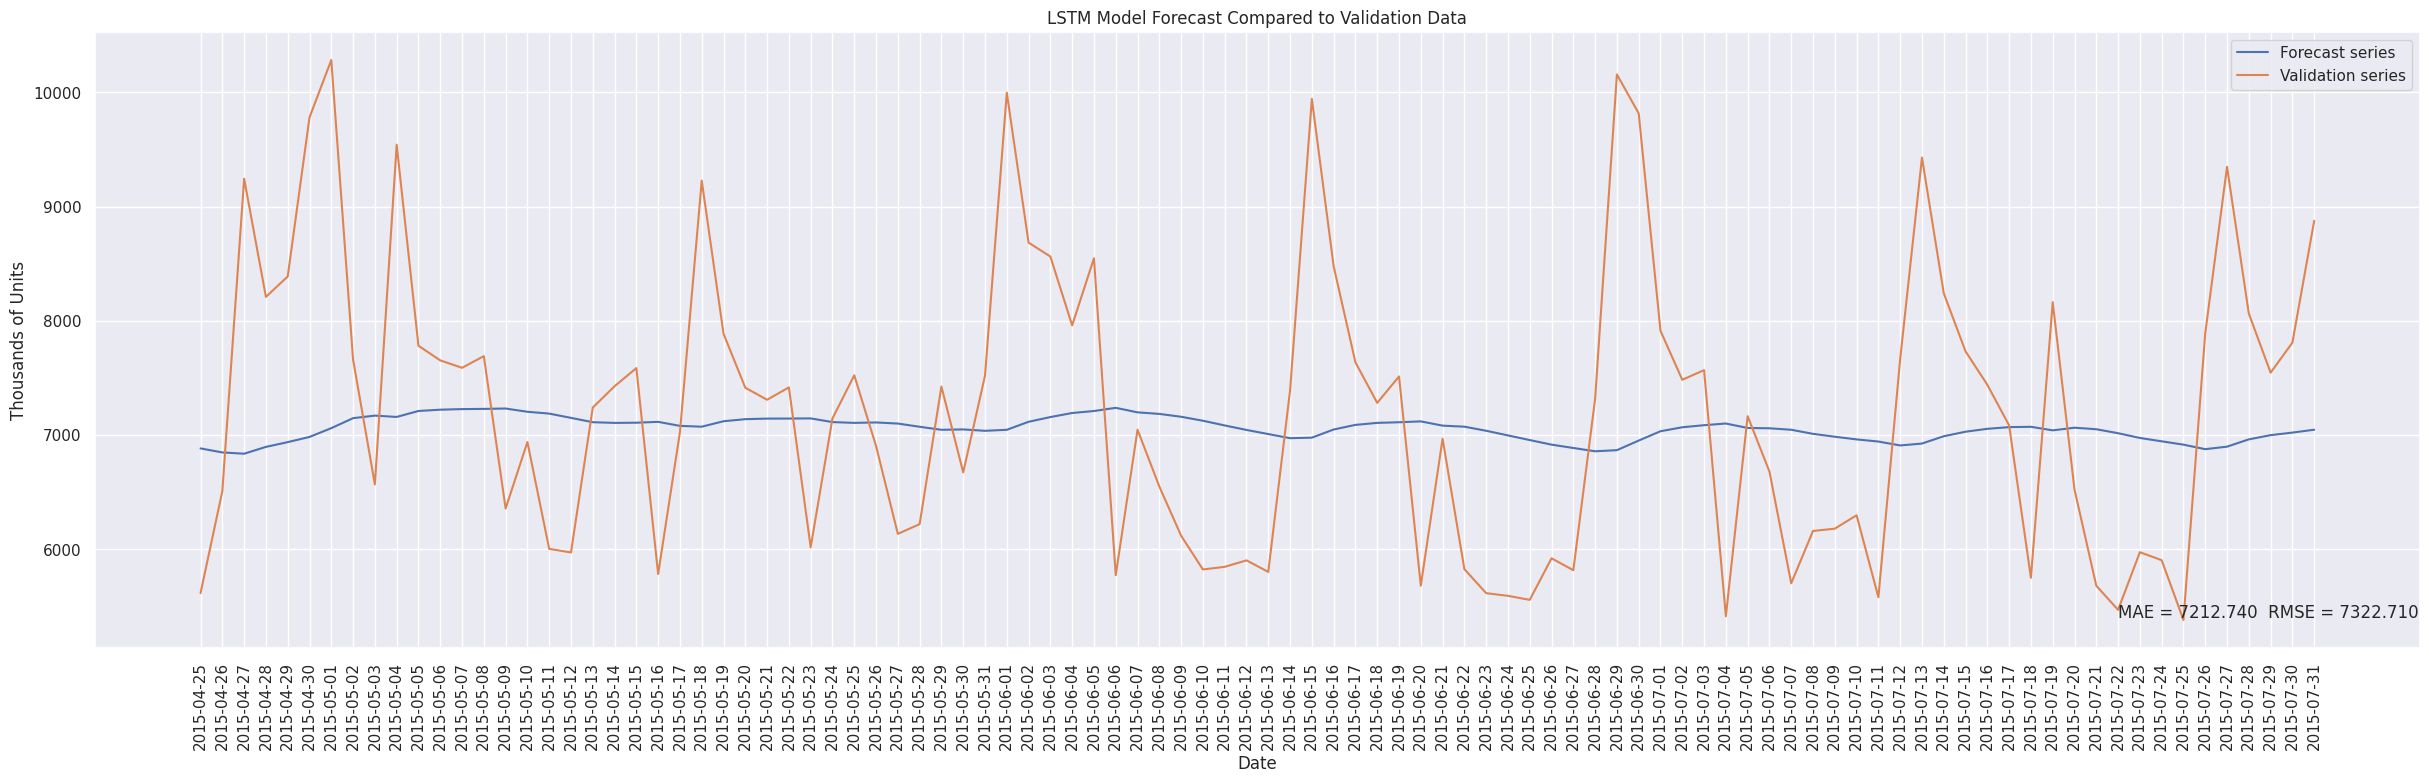

In [40]:

forecast, fig, MAE, RMSE = t.model_forecast_test(model1)

In [41]:
#Forecast the sales of next

def forecast_next_one_sale(model, sales):
    data_feat = None
    WINDOW_SIZE = 49
    try:
        data_feat = sales[["Sales", "Date"]]

        if (data_feat.shape[0] < 49):
            print("To make prediction, we need atleast data of 49 dates")
            return
        scaled_df, scaler_obj = add_scaled_sales(data_feat)
        data_feat["Sales"].isna().any().sum()
        SIZE = len(data_agg["Sales"])


        series = scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE))
        ds = ds.batch(SIZE).prefetch(1)

        forecast = model.predict(ds)
        Results = list(forecast.reshape(1, forecast.shape[0] * forecast.shape[1])[0].copy())

        Results1 = scaler_obj.inverse_transform(forecast.reshape(-1,1))
        Results1 = list(Results1.reshape(1, Results1.shape[0] * Results1.shape[1])[0])




        return  Results1, Results

    except KeyError:
        print("Sales Data is expeceted to have Sales and Date columns")
        return False



def forecast_next_sales(model, sales, daysToForecast=1):
    forecasts = []
    scaled_forecasts = []
    dates = []

    new_sales_df = sales.copy()
    while len(forecasts) < daysToForecast:
        forecast, scaled_forecast = forecast_next_one_sale(model1, new_sales_df)
        forecasts += forecast

        scaled_forecasts += scaled_forecast
        size=len(new_sales_df["Sales"])

        truncated_sales = new_sales_df.tail(size - len(scaled_forecast))

        new_sales = truncated_sales['Sales'].to_list() + scaled_forecast
        next_dates = []

        for i in range(len(scaled_forecast)):
            next_date = new_sales_df["Date"].to_list()[-1] + datetime.timedelta(days=1)
            next_dates.append(next_date)

        new_dates = truncated_sales['Date'].to_list() + next_dates
        new_sales_df = pd.DataFrame()
        new_sales_df["Date"] = new_dates
        new_sales_df["Sales"] = new_sales

    res_df = pd.DataFrame()
    res_df["Date"] = new_dates
    res_df["forecasts"] = forecasts

    return res_df

In [42]:

data_agg["Date"] = data_agg.index
data_agg["Date"] = data_agg["Date"].astype("datetime64")
res_df = forecast_next_sales(model1, data_agg.head(49), 49)
res_df

1/1 [==============================] - 0s 148ms/step


,Date,forecasts
0,2013-02-19,6537.740234
1,2013-02-20,4264.363281
2,2013-02-21,4116.490234
3,2013-02-22,3973.554199
4,2013-02-23,3837.020752
5,2013-02-24,3707.765869
6,2013-02-25,3585.883789
7,2013-02-26,3439.492188
8,2013-02-27,3331.851074
9,2013-02-28,3230.234863


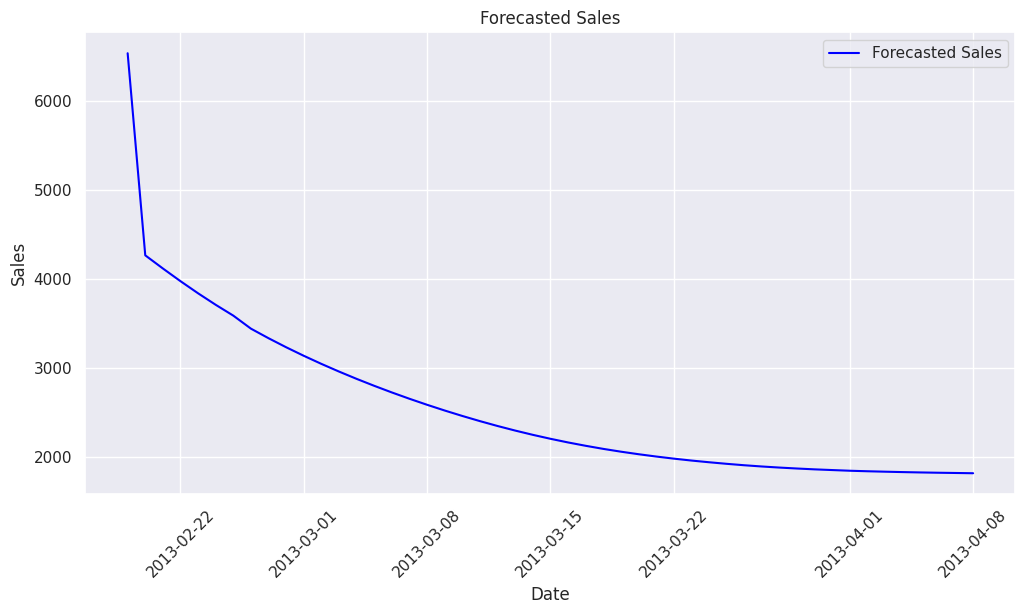

In [43]:

# Extract the date and forecasted sales from the res_df DataFrame
forecast_dates = res_df["Date"]
forecasted_sales = res_df["forecasts"]

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecasted_sales, label="Forecasted Sales", color="blue")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Forecasted Sales")

# Display a legend
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.show()

In [44]:

local_model_path = "/content/drive/MyDrive/Deep learning"

# Save the model to the specified path
model1.save(local_model_path)